# 20220607 Todo list conclusion
1. baseline을 잡기 위해 rough하게 모델링
    - 데이터 살펴보고 object type columns(4개) drop하고 모델링 진행함
        - LinearRegression MAE : 0.092592
        - Lasso MAE : 0.120861
        - Ridge MAE : 0.092592
        - LGBMRegressor MAE : 0.060401
        - XGBRegressor MAE : 0.069529

2. target value인 winPlacePerc와의 상관관계 파악 후 0에 가까운 columns 상의 후 drop
    - 결론 : 팀원들과 상의해본 결과 'matchDuration', 'rankPoints', 'roadKills', 'teamKills' 4개 columns drop으로 결정

# 20220608~20220609 Todo 
1. object dtype(4개) + drop할 columns(4개) drop후 rough하게 모델링
2. EDA 및 데이터 전처리(이상치)
    - 팀원별로 담당한 columns가 다름
    - 내가 담당한 columns
        - longestKill
        - headshotKills
        - killStreaks
        - kills
        - DBNOs
        - damageDealt
    - 가설 세운 후 EDA로 가설 검증
    - 이를 토대로 데이터 전처리 진행


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

## columns 설명

- Id - 플레이어의 Id
- groupId - 경기 내의 그룹을 식별하는 ID. 현재 그룹의 선수들이 서로 다른 경기에서 경기한다면, 그들은 매번 다른 groupId를 갖게 될 것이다.
- matchId - 경기를 식별하기 위한 ID. train set과 test set에 모두 있는 시합은 없다.
- matchDuration - 경기 시간.
- matchType - 경기 종류(duo, quad ...).
- assists - 팀 동료들과 같이 죽인 적 수이다.
- boosts - 부스트 아이템 사용한 수.
- damageDealt - 가한 데미지 총량. Note: 자신에게 가한 데미지는 제외.
- DBNOs - 빈사상태로 만든 적의 수.
- headshotKills - 헤드샷 으로 처리한 적의 수.
- heals - 치료 아이템 사용 수.
- killPlace - 경기에서 처치한 적의 수 랭킹.
- killPoints - 플레이어의 처치 기반 외부 랭킹 (Elo 방식의 순위). rankPoints에서 -1이 아닌 값이 있는 경우, 
- killPoints에서 0은 "없음"으로 처리되어야 한다.
- kills - 처치한 적의 수.
- killStreaks - 단기간에 가장 많이 처치한 적의 최대치.
- longestKill - 플레이어가 적을 죽인 가장 긴 거리. 선수를 다운시키고 멀리 운전하는 것이 가장 긴 처치로 이어질 수 있기 때문에 오해의 소지가 있을 수 있다.
- maxPlace - 경기에서 가장 순위가 낮은 것에 대한 데이터. 이것은 순위를 건너뛸 수도 있기 때문에 numGroups와 일치하지 않을 수 있다.
- numGroups - 경기에 있는 팀의 수.
- rankPoints - Elo 방식의 플레이어 랭킹. 다음 버전의 API에서는 삭제될 예정이기 때문에 사용에 주의. '-1' 값은 순위가 "None" 이다.
- revives - 플레이어가 팀원 회복 시킨 수.
- rideDistance - 차량으로 이동한 거리(단위 : 미터).
- roadKills - 차량으로 죽인 플레이어 수.
- swimDistance - 수영한 거리(단위 : 미터).
- teamKills - 팀킬한 횟수.
- vehicleDestroys - 차량을 폭파시킨 횟수.
- walkDistance - 걸은 총 거리(단위 : 미터).
- weaponsAcquired - 무기 얻은 갯수.
- winPoints - 플레이어의 승리 기반 외부 랭킹 (Elo 방식의 순위). rankPoints에서 -1이 아닌 값이 있는 경우, 
- winPoints에서 0은 "없음"으로 처리되어야 한다.
- winPlacePerc - 예측 목표. 순위의 퍼센트로 표시되며, 1이면 경기에서 1등이고 0이면 경기에서 꼴지 했다는 것이다. 이것은 numGroups로 계산되는게 아니라, maxPlace로 계산되기 때문에 누락되는 것이 있을수도다

In [ ]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/이어드림스쿨/Project/ML_project/PUBG_ML_team_project/pubg-finish-placement-prediction/train_V2.csv')
data = reduce_mem_usage(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float16
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float16
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float16
 21  roadKills        int8   
 22  swimDistance     float16
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float16
 26  weaponsAcquired  int16  
 27  winPoints   

In [ ]:
ori_data = data.copy()

In [ ]:
pd.set_option('display.max_columns', 30)
data.head(2)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.0,0,0,0,60,1241,0,0,0.0,1306,squad-fpp,28,26,-1,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.5,0,0,0,57,0,0,0,0.0,1777,squad-fpp,26,25,1484,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137


## 1. object dtype(4개) + drop할 columns(4개) drop후 rough하게 모델링

In [ ]:
data.isna().sum() # winPlacePerc 1개 결측치 drop
data = data.dropna()
data.isna().sum()

In [ ]:
# object dtype(4개) + drop할 columns(4개) drop후 rough하게 모델링
data = data.drop(columns=['Id', 'groupId', 'matchId', 'matchType'], axis=1)
data = data.drop(columns=['matchDuration', 'rankPoints', 'roadKills', 'teamKills'], axis=1)

In [ ]:
data.head(2)

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,maxPlace,numGroups,revives,rideDistance,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,0,0.0,0,0,0,60,1241,0,0,0.0,28,26,0,0.000000,0.000000,0,244.75,1,1466,0.444336
1,0,0,91.5,0,0,0,57,0,0,0,0.0,26,25,0,0.004501,11.039062,0,1434.00,5,0,0.640137


In [ ]:
# train, test split
from sklearn.model_selection import train_test_split

X = data.drop(columns='winPlacePerc')
y = data['winPlacePerc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3557572, 20), (889393, 20), (3557572,), (889393,))

In [ ]:
# ML model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_error

In [ ]:
# LinearRegression

model_lr = LinearRegression().fit(X_train, y_train)
pred = model_lr.predict(X_test)
mae = mean_absolute_error(pred, y_test)
print('LinearRegression MAE : %f' %mae)

LinearRegression MAE : 0.096740


In [ ]:
# Lasso

model_ls = Lasso().fit(X_train, y_train)
pred2 = model_ls.predict(X_test)
mae = mean_absolute_error(pred2, y_test)
print('Lasso MAE : %f' %mae)

Lasso MAE : 0.126241


In [ ]:
# Ridge

model_rg = Ridge().fit(X_train, y_train)
pred3 = model_rg.predict(X_test)
mae = mean_absolute_error(pred3, y_test)
print('Ridge MAE : %f' %mae)

Ridge MAE : 0.096740


In [ ]:
# LGBMRegressor

model_lgb = LGBMRegressor().fit(X_train, y_train)
pred4 = model_lgb.predict(X_test)
mae = mean_absolute_error(pred4, y_test)
print('LGBMRegressor MAE : %f' %mae)

LGBMRegressor MAE : 0.063779


In [ ]:
# XGBRegressor

model_xgb = XGBRegressor().fit(X_train, y_train)
pred5 = model_xgb.predict(X_test)
mae = mean_absolute_error(pred5, y_test)
print('XGBRegressor MAE : %f' %mae)

[00:01:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor MAE : 0.072096


In [ ]:
# # RandomForestRegressor

# model_rfr = RandomForestRegressor().fit(X_train, y_train)
# pred6 = model_rfr.predict(X_test)
# mae = mean_absolute_error(pred6, y_test)
# print('RandomForestRegressor MAE : %f' %mae)

In [ ]:
# # SVR

# model_svr = SVR().fit(X_train, y_train)
# pred7 = model_rfr.predict(X_test)
# mae = mean_absolute_error(pred7, y_test)
# print('SVR MAE : %f' %mae)

- LinearRegression MAE : 0.096740
- Lasso MAE : 0.126241
- Ridge MAE : 0.096740
- LGBMRegressor MAE : 0.063779
- XGBRegressor MAE : 0.072096

## 2. EDA 및 데이터 전처리(이상치)
        - longestKill
        - headshotKills
        - killStreaks
        - kills
        - DBNOs
        - damageDealt
- 가설 세운 후 EDA로 가설 검증
- 이를 토대로 데이터 전처리 진행

In [ ]:
my_data = data[['damageDealt', 'DBNOs', 'headshotKills', 'kills', 'killStreaks', 'longestKill', 'winPlacePerc']]
my_data.head(2)

,damageDealt,DBNOs,headshotKills,kills,killStreaks,longestKill,winPlacePerc
0,0.0,0,0,0,0,0.0,0.444336
1,91.5,0,0,0,0,0.0,0.640137


In [ ]:
my_data.corr()

,damageDealt,DBNOs,headshotKills,kills,killStreaks,longestKill,winPlacePerc
damageDealt,1.000000,0.735762,0.613409,0.888784,0.703599,0.563838,0.440506
DBNOs,0.735762,1.000000,0.469923,0.707848,0.646872,0.451422,0.279968
headshotKills,0.613409,0.469923,1.000000,0.674275,0.512882,0.447261,0.277722
kills,0.888784,0.707848,0.674275,1.000000,0.802500,0.602937,0.419915
killStreaks,0.703599,0.646872,0.512882,0.802500,1.000000,0.515097,0.377566
longestKill,0.563838,0.451422,0.447261,0.602937,0.515097,1.000000,0.410153
winPlacePerc,0.440506,0.279968,0.277722,0.419915,0.377566,0.410153,1.000000


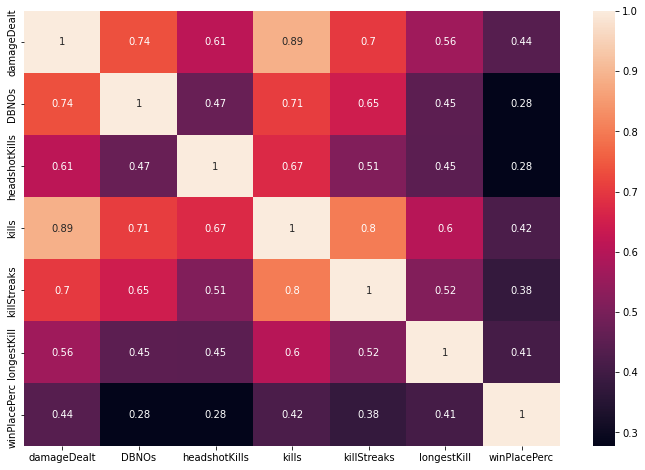

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(data=my_data.corr(), annot = True)
plt.show()

### 가설
1. longestKill이 클수록 headshotKills가 높을 것이다.
2. headshotKills가 높은 유저일수록 Kills, KillStreaks, DBNOs가 높을 것이다.
3. KillStreaks가 높을수록 (짧은 시간에 많은 유저와 싸움) damageDealt가 높을 것이다.

In [ ]:
# columns drop 안한 원본 데이터
ori_data.isna().sum() # winPlacePerc 1개 결측치 drop
ori_data = ori_data.dropna()
ori_data.isna().sum()

In [ ]:
ori_data.head(2)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.0,0,0,0,60,1241,0,0,0.0,1306,squad-fpp,28,26,-1,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.5,0,0,0,57,0,0,0,0.0,1777,squad-fpp,26,25,1484,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137


#### 가설 1. longestKill이 클수록 headshotKills가 높을 것이다.

##### longestKill, headshotKills

In [ ]:
ori_data2 = ori_data.copy()
ori_data3 = ori_data.copy()

In [ ]:
# longestKill이 있어야 Kills수가 있다고 생각했는데..
a = ori_data2[(ori_data2.longestKill == 0)& (ori_data2.kills != 0)][['kills','longestKill','killStreaks', 'headshotKills', 'roadKills', 'teamKills', 'matchType']]
print(a.matchType.value_counts()) # 대부분의 matchType이 있음 -> matchType에 따른 영향 X

print(ori_data2.shape)
print(np.sum(ori_data2.killStreaks == ori_data.kills))
print(np.sum(ori_data2.killStreaks < ori_data.kills))
print(np.sum(ori_data2.killStreaks > ori_data.kills))
# kills count에 KillStreaks count가 합해진다는 것을 의미 -> 상관계수도 0.8로 높으므로 다중공선성 문제 생길 수 있으니 drop 해야한다고 판단

squad-fpp           2578
duo-fpp             2026
solo-fpp            1772
squad               1037
solo                 764
duo                  738
crashfpp              64
normal-squad-fpp      14
flaretpp              12
normal-solo-fpp        3
crashtpp               3
normal-duo-fpp         1
normal-squad           1
Name: matchType, dtype: int64
(4446965, 29)
3611760
835205
0


In [ ]:
a = a.T
total = a.iloc[2:6,:].sum() 
kills = a.iloc[0]

np.sum(total != kills)
# kills count != kills count에 영향을 주는 columns인 경우가 4591
# 이 경우는 차량파괴, 처음 무기를 얻기 전 근거리 공격 등 특수한 경우라 생각 -> 이상치라 판단하여 제거

4591

In [ ]:
# kills count != kills count에 영향을 주는 columns인 경우 drop
ori_data2 = ori_data2.drop(ori_data2[(ori_data2.longestKill == 0)& (ori_data2.kills != 0)].index)

In [ ]:
ori_data3 = ori_data3[(ori_data3.longestKill == 0)& (ori_data3.kills != 0)].T
total = ori_data3.iloc[[7,12,21,23], :].sum()
kills = ori_data3.iloc[11]
total != kills
ori_data3 = ori_data3.loc[:, total == kills].T

In [ ]:
ori_data3.head(2)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
347,707c312fe7decb,d09b94de52ee6e,e1e9ca6ba2e354,0,0,96.0,0,0,1,28,1000,1,1,0.0,1808,duo,43,34,-1,0,0.0,0,0.0,0,0,364.75,1,1500,0.214355
838,01d4aeab2ef3e7,7d224ba7e760ab,34931a75615feb,0,2,100.0,0,0,2,29,0,1,1,0.0,1425,solo-fpp,86,84,1496,0,909.5,0,0.0,0,0,1903.0,6,0,0.717773


In [ ]:
# dataframe concat ori_data2, ori_data3
ori_data2.shape # 4437952
ori_data3.shape # 4422
4437952 + 4422

long_res = pd.concat([ori_data2, ori_data3])
long_res.reset_index(drop=True).shape

(4442374, 29)

In [ ]:
# transpose 2번 실행하니 모든 dtype이 object dtype으로 변경됨.. 처음알았음
long_res[['longestKill', 'winPlacePerc']].astype('float').corr()

# 이상치라 판단한 경우 제거 후 상관관계가 0.410153 에서 0.410515 로 조금 상승함을 확인

,longestKill,winPlacePerc
longestKill,1.000000,0.410515
winPlacePerc,0.410515,1.000000


In [ ]:
# 맵 전체의 크기가 에란겔 기준 8x8km, longestKill의 max는 1094. 따라서 m단위라고 생각
# 최대 스코프가 16배, 따라서, 대략 400m이상은 이상치로 판단
# 유튜브 찾아본 결과 3년 전 영상 중 '배그 최초 M24 948m 저격' 있음

# 배그 거리 관련 블로그 : https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=kimgold1&logNo=221116942560

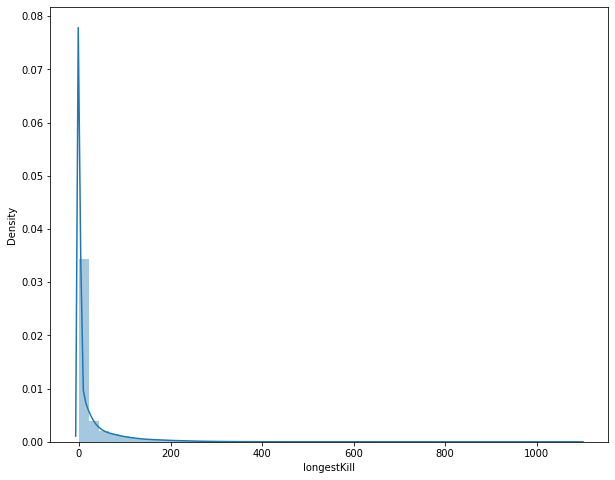

In [ ]:
plt.figure(figsize=(10,8))
sns.distplot(long_res['longestKill'])
plt.show()

In [ ]:
my_data.iloc[:,-2:].corr()

,longestKill,winPlacePerc
longestKill,1.000000,0.410153
winPlacePerc,0.410153,1.000000


In [ ]:
my_data[(my_data.longestKill > 0) & (my_data.longestKill <= 400)].iloc[:,-2:].corr()

,longestKill,winPlacePerc
longestKill,1.000000,0.418957
winPlacePerc,0.418957,1.000000


In [ ]:
# 이상치 제거 안한 기존 데이터에서 상관계수가 0.410153 -> 0.421451로 상승
my_data[my_data.longestKill <= 400].iloc[:,-2:].corr()

,longestKill,winPlacePerc
longestKill,1.000000,0.421451
winPlacePerc,0.421451,1.000000


In [ ]:
# 이상치 제거 한 long_res데이터에서 상관계수가 0.421451 -> 0.421829로 상승
long_res[long_res.longestKill <= 400][['longestKill', 'winPlacePerc']].astype('float').corr()

,longestKill,winPlacePerc
longestKill,1.000000,0.421829
winPlacePerc,0.421829,1.000000


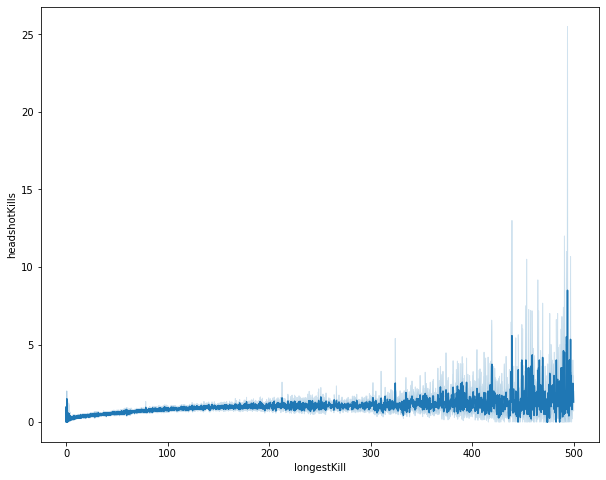

In [ ]:
c = long_res[long_res.longestKill <= 500][['longestKill','headshotKills', 'winPlacePerc']].astype('float')

plt.figure(figsize=(10,8))
sns.lineplot(data=c, x='longestKill', y='headshotKills')
plt.show()

In [ ]:
c.corr()

,longestKill,headshotKills,winPlacePerc
longestKill,1.000000,0.445630,0.417821
headshotKills,0.445630,1.000000,0.278252
winPlacePerc,0.417821,0.278252,1.000000


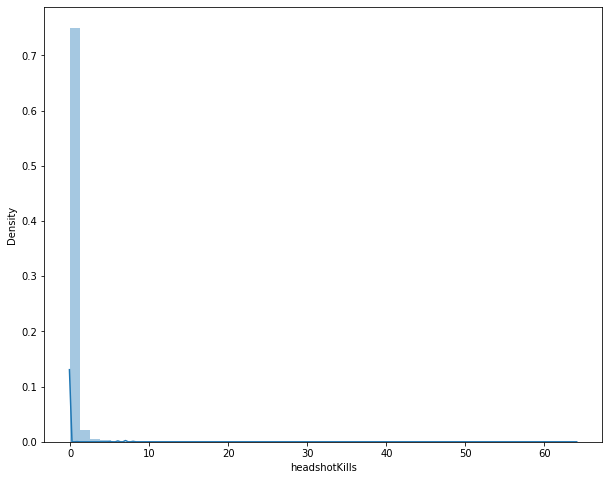

In [ ]:
plt.figure(figsize=(10,8))
sns.distplot(my_data['headshotKills'])
plt.show()

In [ ]:
my_data.iloc[:,[2,6]].corr()

,headshotKills,winPlacePerc
headshotKills,1.000000,0.277722
winPlacePerc,0.277722,1.000000


In [ ]:
# 기존 데이터에서 상관계수가 0.277722 -> 0.281942로 상승
my_data[my_data.headshotKills<10].iloc[:,[2,6]].corr()

,headshotKills,winPlacePerc
headshotKills,1.000000,0.281942
winPlacePerc,0.281942,1.000000


In [ ]:
my_data.iloc[:,[2,5,6]].corr()

,headshotKills,longestKill,winPlacePerc
headshotKills,1.000000,0.447261,0.277722
longestKill,0.447261,1.000000,0.410153
winPlacePerc,0.277722,0.410153,1.000000


In [ ]:
my_data[(my_data.headshotKills<10) & (my_data.longestKill <= 400)].corr()

,damageDealt,DBNOs,headshotKills,kills,killStreaks,longestKill,winPlacePerc
damageDealt,1.000000,0.735563,0.605234,0.886638,0.705163,0.571562,0.441911
DBNOs,0.735563,1.000000,0.467257,0.708979,0.648637,0.454220,0.279273
headshotKills,0.605234,0.467257,1.000000,0.668044,0.516986,0.450387,0.281273
kills,0.886638,0.708979,0.668044,1.000000,0.805571,0.615026,0.421106
killStreaks,0.705163,0.648637,0.516986,0.805571,1.000000,0.530552,0.376540
longestKill,0.571562,0.454220,0.450387,0.615026,0.530552,1.000000,0.421353
winPlacePerc,0.441911,0.279273,0.281273,0.421106,0.376540,0.421353,1.000000


#### 가설 2.headshotKills가 높은 유저일수록 Kills, KillStreaks, DBNOs가 높을 것이다.

In [ ]:
my_data.kills.value_counts()

0     2529721
1      928079
2      472466
3      232441
4      124543
5       66577
6       37960
7       21816
8       12779
9        7644
10       4599
11       2799
12       1755
13       1137
14        757
15        484
16        325
17        234
18        165
19        112
20        109
22         77
21         70
23         47
24         44
25         27
26         27
28         22
27         21
30         13
29         13
31         13
33         12
36          8
38          7
35          7
34          5
41          5
37          5
32          4
53          4
40          4
39          4
43          3
42          3
56          2
55          2
44          2
46          2
57          2
49          1
45          1
47          1
48          1
50          1
66          1
65          1
72          1
Name: kills, dtype: int64

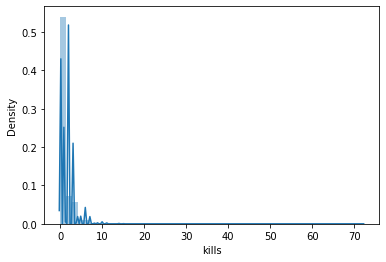

In [ ]:
sns.distplot(my_data['kills'])

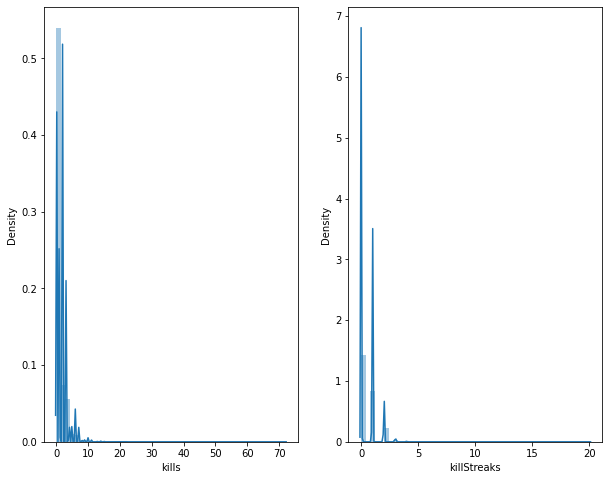

In [ ]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
sns.distplot(my_data['kills'])

plt.subplot(1,2,2)
sns.distplot(my_data['killStreaks'])

plt.show()

In [ ]:
my_data.iloc[:,[2,5,6]].corr()

In [ ]:
my_data.corr()

,damageDealt,DBNOs,headshotKills,kills,killStreaks,longestKill,winPlacePerc
damageDealt,1.000000,0.735762,0.613409,0.888784,0.703599,0.563838,0.440506
DBNOs,0.735762,1.000000,0.469923,0.707848,0.646872,0.451422,0.279968
headshotKills,0.613409,0.469923,1.000000,0.674275,0.512882,0.447261,0.277722
kills,0.888784,0.707848,0.674275,1.000000,0.802500,0.602937,0.419915
killStreaks,0.703599,0.646872,0.512882,0.802500,1.000000,0.515097,0.377566
longestKill,0.563838,0.451422,0.447261,0.602937,0.515097,1.000000,0.410153
winPlacePerc,0.440506,0.279968,0.277722,0.419915,0.377566,0.410153,1.000000


In [ ]:
my_data[my_data.kills < 12].iloc[:,[1,2,3,4,6]].corr()

,DBNOs,headshotKills,kills,killStreaks,winPlacePerc
DBNOs,1.000000,0.461601,0.715707,0.653344,0.281029
headshotKills,0.461601,1.000000,0.655814,0.514567,0.281030
kills,0.715707,0.655814,1.000000,0.820157,0.430556
killStreaks,0.653344,0.514567,0.820157,1.000000,0.375814
winPlacePerc,0.281029,0.281030,0.430556,0.375814,1.000000


In [ ]:
my_data.killStreaks.value_counts()

0     2529721
1     1475558
2      389346
3       45958
4        5711
5         409
6         126
7          54
8          32
9          18
10          9
11          8
13          5
12          5
14          2
16          1
18          1
20          1
Name: killStreaks, dtype: int64

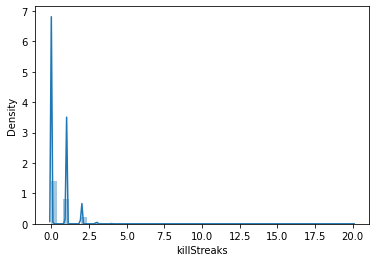

In [ ]:
sns.distplot(my_data['killStreaks'])

### longestKill

In [ ]:
data.kills.max() # 72
data[data.kills == 72]
data[data.groupId == '4c4ee1e9eb8b5e']
# 한 스쿼드가 총 107명을 죽임 -> 이상치라 판단

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
65128,249c1ce67f8f08,4c4ee1e9eb8b5e,6680c7c3d17d48,8,9,1684.0,0,3,10,21,0,14,1,48.0625,1800,normal-squad,15,15,1500,0,0.0,0,0.0,1,0,62.78125,46,0,1.0
1257861,0c9626ffd14e1c,4c4ee1e9eb8b5e,6680c7c3d17d48,6,5,1833.0,0,9,1,14,0,21,2,76.6250,1800,normal-squad,15,15,1500,0,0.0,0,0.0,0,0,245.25000,42,0,1.0
3431247,06308c988bf0c2,4c4ee1e9eb8b5e,6680c7c3d17d48,7,4,5992.0,0,64,10,1,0,72,7,78.2500,1800,normal-squad,15,15,1500,0,0.0,0,0.0,0,0,728.00000,35,0,1.0


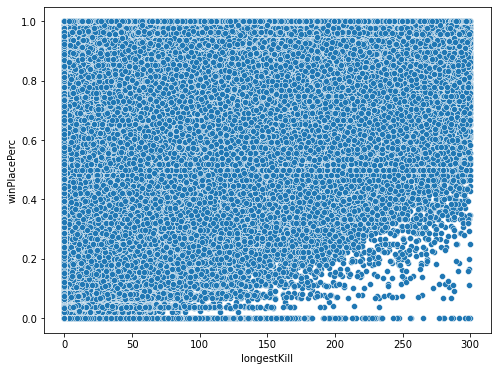

In [ ]:
long = train[train.longestKill <= 300]

plt.figure(figsize=(8,6))
sns.scatterplot(data=long, x='longestKill', y='winPlacePerc')
plt.show()

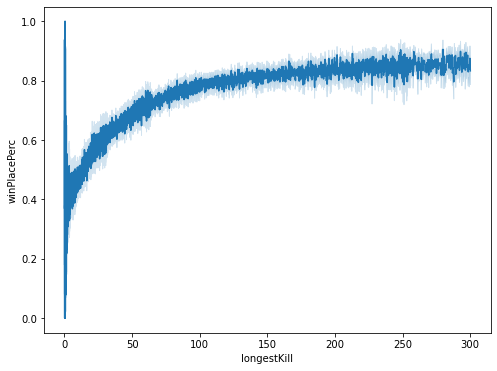

In [ ]:
plt.figure(figsize=(8,6))
sns.lineplot(data=long, x='longestKill', y='winPlacePerc')
plt.show()

In [ ]:
train[train.headshotKills <= 10].iloc[:, [4,20]].corr()

,headshotKills,winPlacePerc
headshotKills,1.0000,0.2817
winPlacePerc,0.2817,1.0000


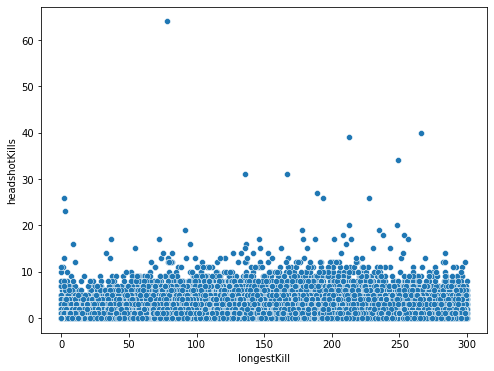

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=long, x='longestKill', y='headshotKills')
plt.show()

In [ ]:
train.headshotKills.value_counts()

0     2956605
1      459921
2      101198
3       26379
4        7998
5        2905
6        1161
7         602
8         287
9         172
10        107
11         66
12         52
13         32
14         19
15         14
16         12
17         11
18          9
19          3
26          3
20          2
31          2
23          2
27          2
34          2
40          1
41          1
35          1
64          1
42          1
39          1
Name: headshotKills, dtype: int64

<AxesSubplot:xlabel='longestKill', ylabel='Density'>

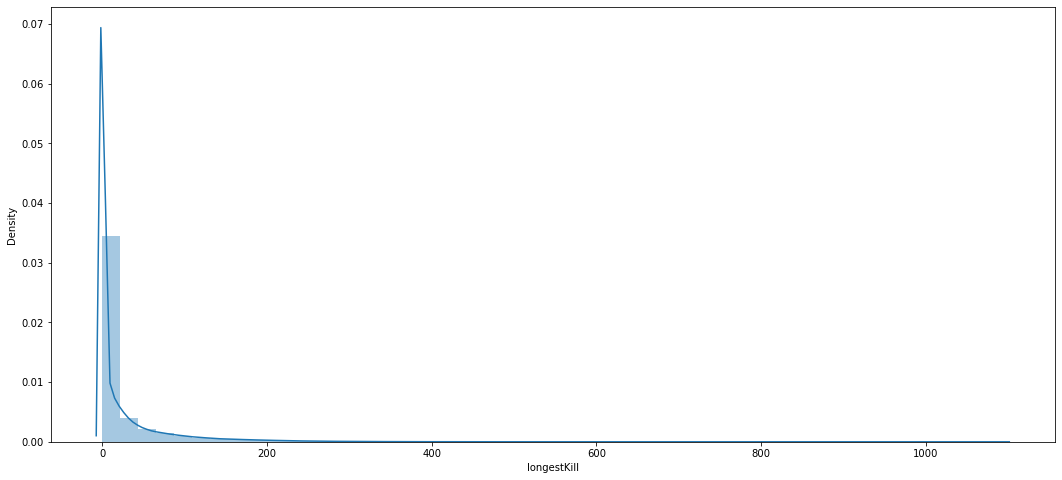

In [ ]:
f, ax = plt.subplots(figsize=(18, 8))
sns.distplot(train['longestKill'])

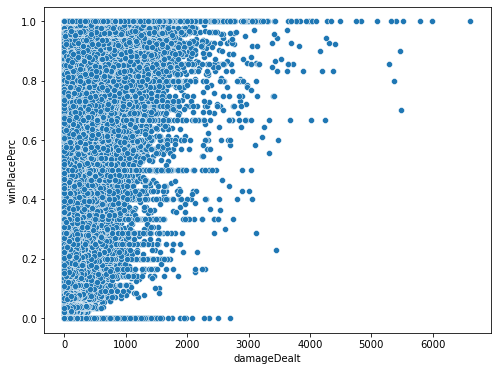

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=train, x='damageDealt', y='winPlacePerc')
plt.show()

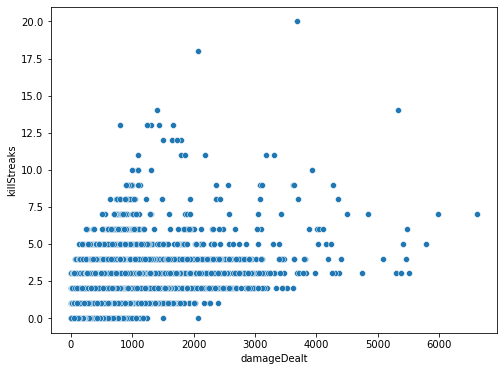

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=train, x='damageDealt', y='killStreaks')
plt.show()

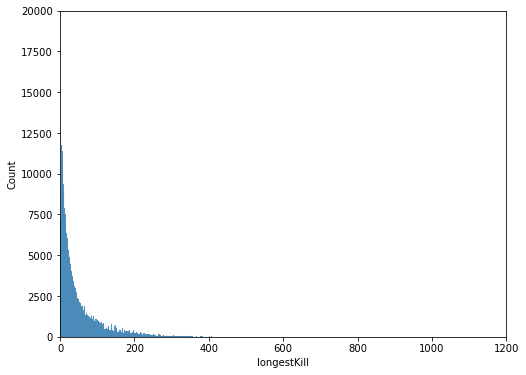

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data=train, x='longestKill')
plt.xlim([0, 1200])
plt.ylim([0,20000])
plt.show()

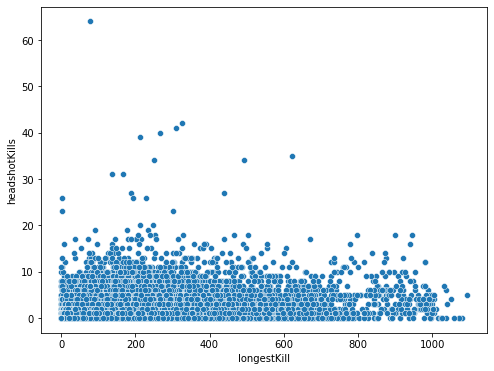

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=train, x='longestKill', y = 'headshotKills')
plt.show()

In [ ]:
sns.boxplot()

In [ ]:
train.shape

(3557572, 21)

In [ ]:
train.corr().nlargest(5, 'winPlacePerc')['winPlacePerc'].index

Index(['winPlacePerc', 'walkDistance', 'boosts', 'weaponsAcquired',
       'damageDealt'],
      dtype='object')

In [ ]:
# longestKill가 0인데, kills는 0이 아닌 경우
train[(train.longestKill == 0)& (train.kills != 0)][['kills', 'longestKill']]

# longestKill이 있어야 Kills수가 있다고 생각했는데..


,kills,longestKill
1645136,1,0.0
3667713,1,0.0
20752,4,0.0
4399216,1,0.0
422062,3,0.0
...,...,...
2675480,3,0.0
689556,1,0.0
664468,1,0.0
3334733,1,0.0


## 2. 이상치를 어디에 두고 정의할지 EDA 후 생각

In [ ]:
data.columns[:-1].value_counts().sum()

18

In [ ]:
data.head(2)

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,numGroups,revives,rideDistance,swimDistance,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc
0,0,0,0.0,0,0,0,60,1241,0,0,0.0,26,0,0.000000,0.000000,0,244.75,1,0.444336
1,0,0,91.5,0,0,0,57,0,0,0,0.0,25,0,0.004501,11.039062,0,1434.00,5,0.640137


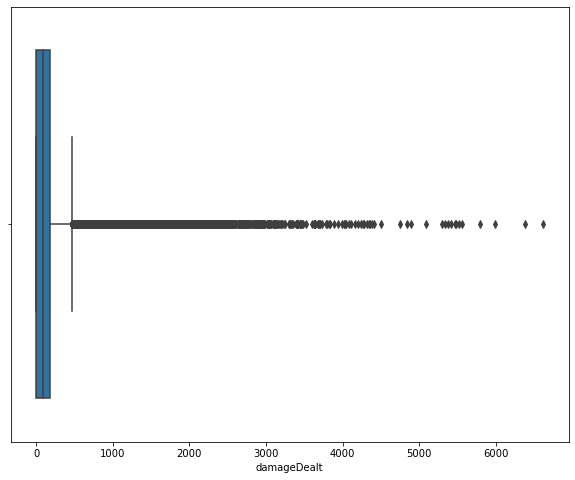

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(data=data, x='damageDealt')
plt.show()

<AxesSubplot:xlabel='assists', ylabel='Count'>

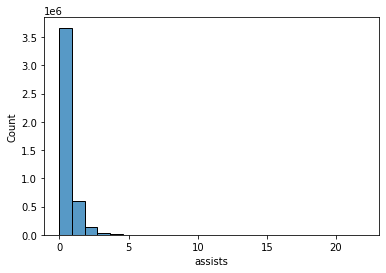

In [ ]:
sns.histplot(data=data, x='assists')

In [ ]:
# 10이상인 것을 이상치라고 생각
data.assists.value_counts()

0     3667659
1      591883
2      137144
3       35640
4        9990
5        2892
6         976
7         387
8         185
9          84
10         48
11         27
12         20
13         16
15          7
14          2
17          2
21          1
20          1
22          1
Name: assists, dtype: int64

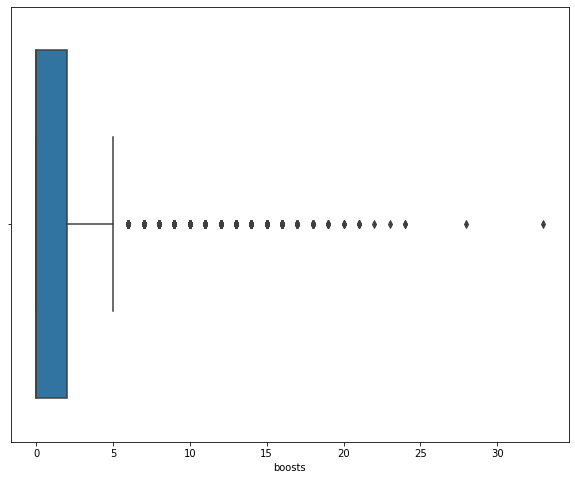

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(data=data, x='boosts')
plt.show()

In [ ]:
# 15개 이상을 이상치라고 생각
data.boosts.value_counts()

0     2521323
1      680252
2      491316
3      295883
4      195729
5      120271
6       70111
7       37626
8       18893
9        8638
10       3992
11       1644
12        726
13        295
14        126
15         62
16         30
17         16
18         13
19          6
21          4
20          3
24          2
33          1
28          1
23          1
22          1
Name: boosts, dtype: int64

In [ ]:
data.columns

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'numGroups', 'revives', 'rideDistance', 'swimDistance',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPlacePerc'],
      dtype='object')

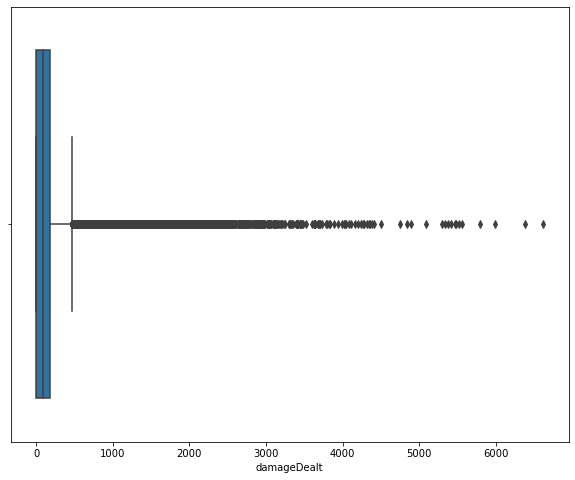

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(data=data, x='damageDealt')
plt.show()

In [ ]:
sorted(data.damageDealt)[-5:]

[5556.0, 5792.0, 5992.0, 6376.0, 6616.0]

In [ ]:
data.damageDealt.value_counts()

0.000000      1238101
100.000000     262998
200.000000      62398
300.000000      14306
75.000000       13751
               ...   
0.631348            1
0.446777            1
0.506348            1
0.139160            1
0.870605            1
Name: damageDealt, Length: 12925, dtype: int64